## ANN approach for ARM


In [1]:
"""
@author: Dr. H K Patel, Pankaj, Aditya
"""
import time
start = time.time()
from sklearn.decomposition import NMF
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score

import warnings
warnings.simplefilter("ignore", UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
cols = ['1','2','3','4','5','6','7','8','9','10','11','12',
        '13','14','15','16','17','18','19','20','21','22',
        '23','24','25','26','27','28','29','30','31','32']

df = pd.read_csv("groceries.csv", sep = ",", 
                 names = cols, engine = "python")
data = np.array(df)
df.head(5)

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,citrus fruit,semi-finished bread,margarine,ready soups,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,tropical fruit,yogurt,coffee,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,whole milk,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,pip fruit,yogurt,cream cheese,meat spreads,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,other vegetables,whole milk,condensed milk,long life bakery product,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [3]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
count,9835,7676,6033,4734,3729,2874,2229,1684,1246,896,...,14,8,7,7,6,5,4,1,1,1
unique,158,151,155,153,150,137,138,140,128,120,...,13,7,6,7,5,4,3,1,1,1
top,sausage,whole milk,whole milk,whole milk,rolls/buns,soda,soda,shopping bags,soda,shopping bags,...,waffles,bottled beer,chocolate,long life bakery product,hygiene articles,napkins,house keeping products,skin care,hygiene articles,candles
freq,825,654,506,315,176,150,120,76,61,49,...,2,2,2,1,2,2,2,1,1,1


In [3]:
df.shape

(9835, 32)

In [4]:
def get_unique_items(data):
    ncol = data.shape[1]
    items = set()
    for c in range(ncol):
        items = items.union(data[:,c])
    items = np.array(list(items))
    items = items[items != np.array(None)]

    return np.unique(items)

In [5]:
def get_onehot_items(data,unique_items):
    onehot_items = np.zeros((len(data),len(unique_items)),dtype = np.int)
    for i, r in enumerate(data):
        for j, c in enumerate(unique_items):
            onehot_items[i,j] = int(c in r)
            
    return onehot_items


In [6]:
def get_items_from_ohe(ohe,unique_items):
    return unique_items[np.flatnonzero(ohe)]

In [7]:
unique_items = get_unique_items(data)
onehot_items = np.array(get_onehot_items(data, unique_items))


n = 15
item_counts = (onehot_items != 0).sum(0)
items_max_args = item_counts.argsort()[-n:][::-1]
ic = pd.DataFrame({"Items":unique_items[items_max_args], "Frequency":item_counts[items_max_args]})


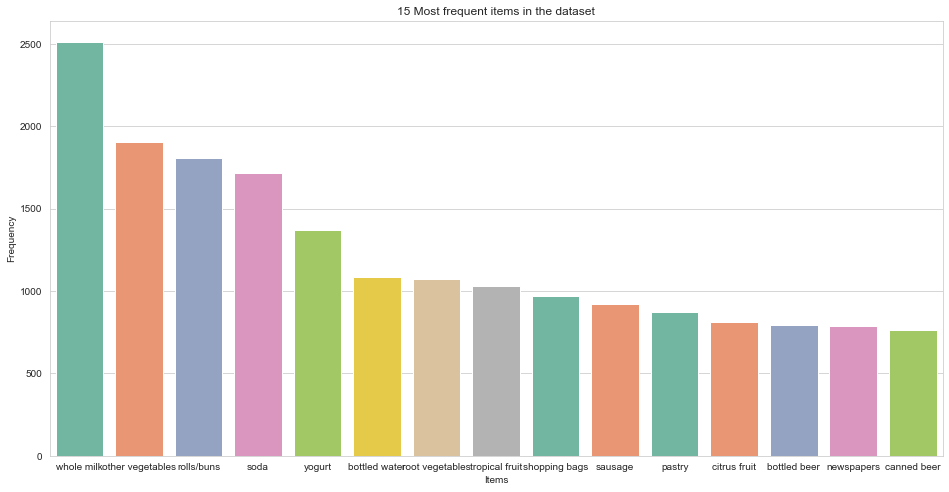

In [8]:
fig = plt.figure(figsize = (16,8))
sns.barplot(x="Items", y="Frequency", data=ic, palette=sns.color_palette("Set2", 10))
plt.xlabel("Items")
plt.ylabel("Frequency")
plt.title(str(n) + " Most frequent items in the dataset")
plt.show()

In [9]:
train_test_split = np.random.rand(len(onehot_items)) < 0.80
train_x = onehot_items[train_test_split]
test_x = onehot_items[~train_test_split]
print()


In [10]:
train_validation_split = np.random.rand(len(train_x)) < 0.80
validation_x = train_x[~train_validation_split]
train_x = train_x[train_validation_split]

In [11]:
def weight_variable(weight_name, weight_shape):
    return tf.get_variable(name = "weight_" + weight_name,shape = weight_shape, 
            initializer = tf.contrib.layers.xavier_initializer()) 

In [12]:
def bias_variable(bias_shape):
    initial = tf.constant(0.1, shape = bias_shape)
    return tf.Variable(initial)

In [13]:
def encoder(x):
    l1 = tf.nn.softsign(tf.add(tf.matmul(x,e_weights_h1),e_biases_h1))
    l2 = tf.nn.softsign(tf.add(tf.matmul(l1,e_weights_h2),e_biases_h2))
    l3 = tf.nn.softsign(tf.add(tf.matmul(l2,e_weights_h3),e_biases_h3))
    l4 = tf.nn.sigmoid(tf.add(tf.matmul(l3,e_weights_h4),e_biases_h4))
    return l4

In [14]:
def decoder(x):
    l1 = tf.nn.softsign(tf.add(tf.matmul(x,d_weights_h1),d_biases_h1))
    l2 = tf.nn.softsign(tf.add(tf.matmul(l1,d_weights_h2),d_biases_h2))
    l3 = tf.nn.softsign(tf.add(tf.matmul(l2,d_weights_h3),d_biases_h3))
    l4 = tf.nn.sigmoid(tf.add(tf.matmul(l3,d_weights_h4),d_biases_h4))
    return l4

#### Terminology

input_dim = 169

n_hidden_1 = 128
n_hidden_2 = 64
n_hidden_3 = 32
n_hidden_4 = 16

training_epochs = 30
batch_size = 50
total_batches = (train_x.shape[0] // batch_size)

learning_rate = 0.00002
keep_prob = 0.6
l2_reg_rate = 0.00001


In [15]:
input_dim = 169

n_hidden_1 = 128
n_hidden_2 = 64
n_hidden_3 = 32
n_hidden_4 = 16

training_epochs = 30
batch_size = 50
total_batches = (train_x.shape[0] // batch_size)

learning_rate = 0.0002 #0.0002
keep_prob = 0.8
l2_reg_rate = 0.000001

In [16]:
tf.reset_default_graph()

In [17]:
is_training = tf.placeholder_with_default(False, shape = ())
X = tf.placeholder(tf.float32, shape=[None,input_dim])
X_drop = tf.contrib.layers.dropout(X, keep_prob, is_training = is_training)
#X_drop = tf.contrib.layers.dropout(X, keep_prob, noise_shape=None, is_training=True, outputs_collections=None, scope=None, seed=None )
print("X_drop", X_drop)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
X_drop Tensor("Dropout/cond/Merge:0", shape=(?, 169), dtype=float32)


##### --------------------- Encoder Variables --------------- ####

In [18]:
e_weights_h1 = weight_variable("el1",[input_dim, n_hidden_1])
e_biases_h1 = bias_variable([n_hidden_1])

e_weights_h2 = weight_variable("el2",[n_hidden_1, n_hidden_2])
e_biases_h2 = bias_variable([n_hidden_2])

e_weights_h3 = weight_variable("el3",[n_hidden_2, n_hidden_3])
e_biases_h3 = bias_variable([n_hidden_3])

e_weights_h4 = weight_variable("el4",[n_hidden_3, n_hidden_4])
e_biases_h4 = bias_variable([n_hidden_4])
e_biases_h4

<tf.Variable 'Variable_3:0' shape=(16,) dtype=float32_ref>



#### --------------------- Decoder Variables --------------- ####

In [19]:
d_weights_h1 = weight_variable("dl1",[n_hidden_4, n_hidden_3])
d_biases_h1 = bias_variable([n_hidden_3])

d_weights_h2 = weight_variable("dl2",[n_hidden_3, n_hidden_2])
d_biases_h2 = bias_variable([n_hidden_2])

d_weights_h3 = weight_variable("dl3",[n_hidden_2, n_hidden_1])
d_biases_h3 = bias_variable([n_hidden_1])

d_weights_h4 = weight_variable("dl4",[n_hidden_1, input_dim])
d_biases_h4 = bias_variable([input_dim])

In [20]:
encoded = encoder(X_drop)
print("HHHH==",encoded)
decoded = decoder(encoded)
print("MMMM==", decoded) 

HHHH== Tensor("Sigmoid:0", shape=(?, 16), dtype=float32)
MMMM== Tensor("Sigmoid_1:0", shape=(?, 169), dtype=float32)


In [21]:
regularizer = tf.contrib.layers.l2_regularizer(l2_reg_rate)
reg_loss = regularizer(e_weights_h1) + regularizer(e_weights_h2) + regularizer(e_weights_h3) + regularizer(e_weights_h4) 
cost_function = -tf.reduce_mean(((X * tf.log(decoded)) + ((1 - X) * tf.log(1 - decoded)))) + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_function)

In [22]:
with tf.Session() as session:
    Tr_loss=[]
    Val_loss=[]
    tf.global_variables_initializer().run()
    print("Epoch","  ","Tr. Loss"," ","Val. Loss")
    for epoch in range(training_epochs):
        for b in range(total_batches):
            offset = (b * batch_size) % (train_x.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :] 
            _, c = session.run([optimizer, cost_function],feed_dict={X: batch_x, is_training: True})
    
        tr_c = session.run(cost_function,feed_dict={X: train_x, is_training: False})
        val_c = session.run(cost_function,feed_dict={X: validation_x, is_training: False})
        print(epoch+1,"\t",tr_c," ",val_c)
        Tr_loss.append(tr_c)
        Val_loss.append(val_c)
    
    tr_p = session.run(decoded,feed_dict={X: train_x, is_training: False})
    roc_auc = roc_auc_score(train_x,tr_p,average = "samples")
    print("Training ROC AUC: ", round(roc_auc,4))

    val_p = session.run(decoded,feed_dict={X: validation_x, is_training: False})
    roc_auc = roc_auc_score(validation_x,val_p,average = "samples")
    print("Validation ROC AUC: ", round(roc_auc,4))
    
    ts_p = session.run(decoded,feed_dict={X: test_x, is_training: False})
    roc_auc = roc_auc_score(test_x,ts_p,average = "samples")
    print("Test ROC AUC: ", round(roc_auc,4),"\n")
    
    item_preds = session.run(decoded,feed_dict={X: test_x.reshape(-1,169), is_training: False})
    print("ttt==",len(item_preds))
    item_preds[item_preds >= 0.05] = 1
    item_preds[item_preds < 0.05] = 0
    

Epoch    Tr. Loss   Val. Loss
1 	 0.22497115   0.22535245
2 	 0.11879839   0.119275674
3 	 0.10681602   0.10719056
4 	 0.10358551   0.10387511
5 	 0.10233594   0.10256155
6 	 0.101754844   0.10193597
7 	 0.10145085   0.1016024
8 	 0.10127689   0.101408936
9 	 0.10116934   0.101288415
10 	 0.10109739   0.101207815
11 	 0.10104249   0.10114759
12 	 0.10095656   0.10106688
13 	 0.09705432   0.09722228
14 	 0.09560334   0.09579666
15 	 0.09503177   0.095214486
16 	 0.09463158   0.09479961
17 	 0.09431613   0.094478086
18 	 0.09408525   0.094234295
19 	 0.093896076   0.094033785
20 	 0.093734905   0.093864016
21 	 0.09358271   0.093707345
22 	 0.093453966   0.09357235
23 	 0.093320325   0.09343537
24 	 0.09318442   0.09330019
25 	 0.09304089   0.09315302
26 	 0.09290644   0.09301836
27 	 0.09275755   0.09287665
28 	 0.092581265   0.09270759
29 	 0.09242584   0.09256386
30 	 0.09227647   0.092428386
Training ROC AUC:  0.8372
Validation ROC AUC:  0.8422
Test ROC AUC:  0.8409 

ttt== 1967


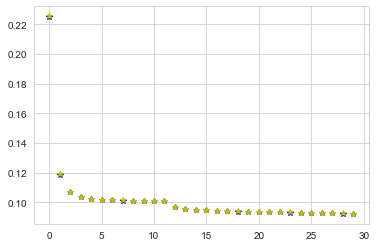

In [24]:
plt.plot(Tr_loss,'b*', Val_loss, 'y*')
plt.show()

In [25]:
"""   
i = 100
#print("Items in basket: ",get_items_from_ohe(test_x[i],unique_items))
print("Recommended item(s): ",get_items_from_ohe(item_preds[i],unique_items))
"""
model = NMF(n_components=100, init='random', random_state=0)
transation_w = model.fit_transform(item_preds)
items_h = model.components_

#get_items_from_ohe(items_h[1],unique_items)

print("Frequent item(s): ",get_items_from_ohe(items_h[0],unique_items))

Frequent item(s):  ['UHT-milk' 'beef' 'bottled beer' 'bottled water' 'brown bread' 'butter'
 'canned beer' 'cat food' 'chicken' 'chocolate' 'citrus fruit' 'coffee'
 'cream cheese ' 'curd' 'dessert' 'domestic eggs' 'frankfurter'
 'frozen vegetables' 'fruit/vegetable juice' 'hamburger meat'
 'long life bakery product' 'margarine' 'meat' 'napkins' 'newspapers'
 'other vegetables' 'pastry' 'photo/film' 'pip fruit' 'pork' 'rolls/buns'
 'root vegetables' 'salty snack' 'sausage' 'shopping bags' 'soda'
 'tropical fruit' 'waffles' 'whipped/sour cream' 'white bread'
 'whole milk' 'yogurt']


In [26]:
total_transection=9835
for i in range(100):
    xx=np.asarray(np.nonzero(items_h[i]))
    [m,n]=(np.asarray(np.nonzero(items_h[i]))).shape
    support_A_B=len(np.intersect1d(np.nonzero(onehot_items[:,xx[0,n-1]]),np.nonzero(onehot_items[:,xx[0,n-2]])))/total_transection
    #print("{" + str(unique_items[xx[0,n-1]]) + "}" +"=>" "{" + str(unique_items[xx[0,n-2]]) + "}")
    [xxxx,sup_A]=(np.asarray(np.nonzero(onehot_items[:,xx[0,n-1]]))).shape
    [xxxx,sup_B]=(np.asarray(np.nonzero(onehot_items[:,xx[0,n-2]]))).shape
    support_A=sup_A/total_transection
    support_B=sup_B/total_transection
    confidence_A_B=support_A_B / (support_A)
    confidence_B_A=support_A_B / (support_B)
    #lift and conviction
    lift_A_B=confidence_A_B / support_B
    conviction_A_B=(1-support_B)/(1-confidence_A_B)
    print(i+1, "{" + str(unique_items[xx[0,n-1]]) + "}" +"=>" "{" + str(unique_items[xx[0,n-2]]) + "}"+" "+ "support="+ str(round(support_A_B,2)) +" "+ "confidence=" + str(round(confidence_A_B,2))  +" "+ "lift=" + str(round(lift_A_B,2))  +" "+ "conviction=" + str(round(conviction_A_B,2)) )


1 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
2 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
3 {white wine}=>{white bread} support=0.0 confidence=0.03 lift=0.64 conviction=0.98
4 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
5 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
6 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
7 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
8 {yogurt}=>{white wine} support=0.0 confidence=0.01 lift=0.77 conviction=1.0
9 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
10 {yogurt}=>{white bread} support=0.01 confidence=0.06 lift=1.54 conviction=1.02
11 {shopping bags}=>{semi-finished bread} support=0.0 confidence=0.03 lift=1.87 conviction=1.02
12 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
13 {whole milk}=>{whipped/s

In [50]:
#antecedents=[]
#consequents=[]
antecedents=str(unique_items[xx[0,n-1]])
consequents=str(unique_items[xx[0,n-2]])

temp = pd.DataFrame({'Support': str(round(support_A_B,2)), 'Confidence': str(round(confidence_A_B,2)), 'Lift': str(round(lift_A_B,2)), 'Conviction':str(round(conviction_A_B,2)) })
    result_ann = pd.concat([result_ann, temp])

result_ann.to_csv("result_ann.csv", sep=',') 

IndentationError: unexpected indent (<ipython-input-50-24ff34a3f6b2>, line 7)

In [51]:
import csv 
data = [[(antecedents)], [(consequents)], [str(round(support_A_B,2))], [str(round(confidence_A_B,2))],[str(round(lift_A_B,2))],[str(round(conviction_A_B,2))] 
file = open('odd.csv', 'w+', newline ='') 
with file:     
    write = csv.writer(file) 
    #write.writerows(data) 

SyntaxError: invalid syntax (<ipython-input-51-920f45656b82>, line 3)

In [52]:
end = time.time()
print("Time consumed in working: ",end - start)

Time consumed in working:  2420.399659395218


In [53]:
temp = {'Support': str(round(support_A_B,2)), 'Confidence': str(round(confidence_A_B,2)), 'Lift': str(round(lift_A_B,2)), 'Conviction':str(round(conviction_A_B,2)) }
dataframe = pd.DataFrame(temp) 
dataframe.to_csv('result_ann.csv')

ValueError: If using all scalar values, you must pass an index

'1.24'